### Economics 690
### Final Project
### Cooley, Buchanan 
### Project Title: Let's Write A Hit Song

### Import All Of the Packages We Might Need

Some of these packages required me to download them in my command window before I could use them:
pip --user install ntlk,
pip --user install gensim,
pip --user install pyLDAvis,

I also had to update my seaborn package to use certain graphing functions I needed:
pip --user install seaborn==0.9.0

In [1]:
#usually takes about 30 seconds to run
#from class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
#I had to upload an updated verson of seaborn (0.9.0) to run some of my code. I used the --user install method we did in class
import seaborn as sns 
import matplotlib.patches as mpatches
import geopandas     
from shapely.geometry import Point 
#from my own research
#I had to use --user install method to upload many of these packages to my computer before using them
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
#to make our data a little more reasonable 
pd.set_option('precision', 4) 
#ignore the depcration warning

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcooley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bcooley\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


### Pulling in the data I am using, then cleaning it
This data was pulled from three sources:
    song_data is from kaggle
    lyrics_data is from github
    lyrics_data_rank is from kaggle

In [2]:
#to pull in data from github and kaggle -- originally from spotify
#lots of missing data shown as zeros... let's make those NaNs
song_data = pd.read_csv('songdata.csv',na_values=0)
lyrics_data = pd.read_csv('Music_Lyrics.csv',na_values=0)
lyrics_data_rank = pd.read_csv('billboard_lyrics_1964-2015.csv',na_values=0)

In [3]:
#cleaning up the data
#I like my columns to look like titles
lyrics_data.columns = [col_names.title() for col_names in lyrics_data.columns]
#minutes are easier to understand
lyrics_data['Duration_Minutes'] = lyrics_data['Duration_Ms']/60000
#I don't use any of these in my analysis
vars_to_drop = ['Duration_Ms','Pos','F_K_Grade','Artist','Num_Dupes','Neg', 'Neu','Compound','Id','Mode','Uri','Analysis_Url','Artist_With_Features','Image','Cluster']
lyrics_data.drop(vars_to_drop, axis=1, inplace=True)
#I like these names better
lyrics_data.rename(columns={'Num_Syllables':'Syllables','Num_Words':'Words','Num_Lines':'Lines','Year_Bin':'Decade'}, inplace=True)
lyrics_data_rank.drop('Year', axis=1, inplace=True)
#to stay consistent with my title case (for graphing later)
lyrics_data['Gender'] = lyrics_data['Gender'].str.replace('male','Male')
lyrics_data['Gender'] = lyrics_data['Gender'].str.replace('feMale','Female')
#to merge data
lyrics_data_rank['Song'] = lyrics_data_rank['Song'].str.title()
lyrics_data_rank.rename(columns={'Song':'Title'}, inplace=True)
music_data = pd.merge(left=lyrics_data, right=lyrics_data_rank, on=['Title'], how='outer')
#to make the ranking move from left to right instead of vis versa when we plot
music_data['Inverse_Rank'] = music_data['Rank']*-1

### What should the song be about?
I start with some basic word counts, and then use a more complicated approach called "topic modeling."

In [4]:
#to find word counts in lyrics
#to isolate the lyrics
lyrics_data['Lyrics'] = lyrics_data['Lyrics'].str.lower()
word_count = lyrics_data.Lyrics.str.split(expand=True).stack().value_counts()
#to limit our data to high frequency words
word_count_special = word_count >=7500
#to create dataframes
word_count_df = pd.DataFrame(word_count)
word_count_special_df = pd.DataFrame(word_count_special)
#to rename columns
word_count_df = word_count_df.rename(columns={0:'Count'})
word_count_special_df = word_count_special_df.rename(columns={0:'Keep'})
#to merge
word_count_narrow = pd.merge(word_count_df, word_count_special_df, left_index=True, right_index=True)
word_count_narrow = word_count_narrow[word_count_narrow['Keep']==True]

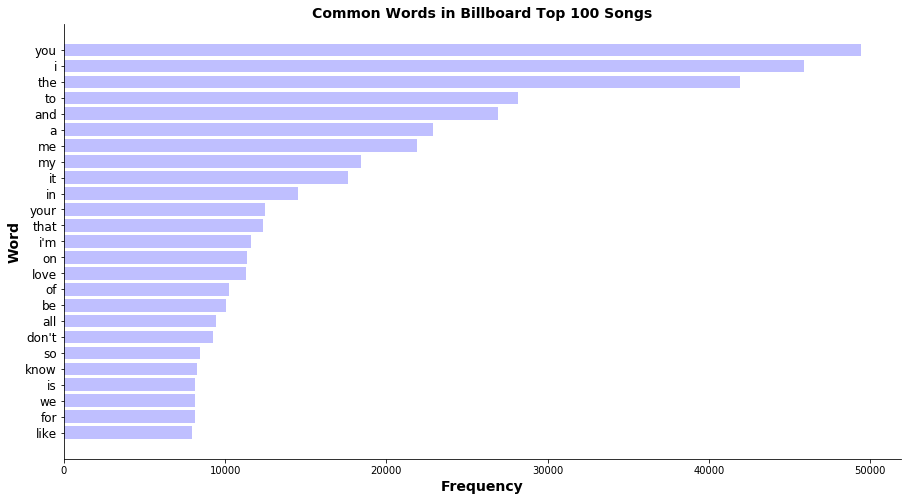

In [5]:
#to plot
word_count_sort= word_count_narrow.sort_values('Count')
fig, ax = plt.subplots(figsize=(15,8))
ax.barh(word_count_sort.index, word_count_sort['Count'], color='blue', alpha=0.25)     
plt.yticks(word_count_sort.index,fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Frequency', fontweight='bold',fontsize=14)
ax.set_ylabel('Word',fontweight='bold',fontsize=14)
ax.set_title('Common Words in Billboard Top 100 Songs',fontsize=14,fontweight='bold')
plt.savefig('Figure_1.png')
plt.show()

In [6]:
#let's get rid of words that are 3 letters or less
#to isolate the lyrics
wide_word_count = lyrics_data.Lyrics.str.split(expand=True).stack().value_counts()
#to limit our data to high frequency words
wide_word_count_special = wide_word_count >=3400
#to create dataframes
wide_word_count_df = pd.DataFrame(wide_word_count)
wide_word_count_special_df = pd.DataFrame(wide_word_count_special)
#to rename columns
wide_word_count_df = wide_word_count_df.rename(columns={0:'Count','index':'Word'})
wide_word_count_special_df = wide_word_count_special_df.rename(columns={0:'Keep'})
#to merge
wide_word_count_narrow = pd.merge(wide_word_count_df, wide_word_count_special_df, left_index=True, right_index=True)
wide_word_count_narrow = wide_word_count_narrow[wide_word_count_narrow['Keep']==True]
#to reset index to allow us to str.len()
wide_word_count_narrow.reset_index(inplace=True)
wide_word_count_narrow = wide_word_count_narrow.rename(columns={'index':'Word'})
wide_word_count_narrow['Length'] = wide_word_count_narrow['Word'].str.len()
#bring index back
wide_word_count_narrow.set_index('Word', inplace=True)
wide_word_count_narrow = wide_word_count_narrow[wide_word_count_narrow['Length']>3]

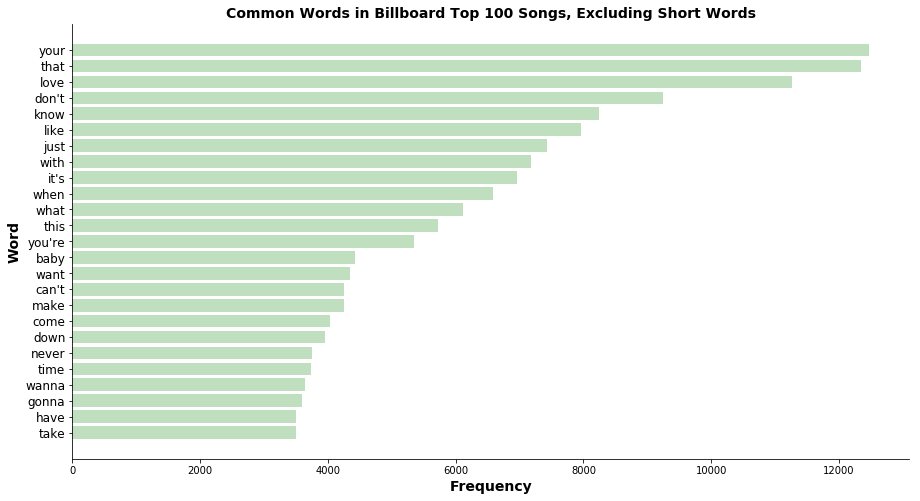

In [7]:
#to plot
wide_word_count_sort = wide_word_count_narrow.sort_values('Count')
fig, ax = plt.subplots(figsize=(15,8))
ax.barh(wide_word_count_sort.index, wide_word_count_sort['Count'], color='green', alpha=0.25)     
plt.yticks(wide_word_count_sort.index,fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Frequency',fontweight='bold',fontsize=14)
ax.set_ylabel('Word',fontweight='bold',fontsize=14)
ax.set_title('Common Words in Billboard Top 100 Songs, Excluding Short Words',fontsize=14,fontweight='bold')
plt.savefig('Figure_2.png')
plt.show()

In [8]:
#usually takes about 15 seconds to run
#let's try topic modeling! 
#to clean up lyrics to prepare for topic modeling
stop = set(stopwords.words('english')) #this removes common filler words
exclude = set(string.punctuation) #this removes puncuation
lemma = WordNetLemmatizer() #this changes third-person to first-person, and past-tense to present-tense
def clean(lyric):
    stop_free = " ".join([i for i in lyric.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
lyrics_data_clean = [clean(lyric).split() for lyric in lyrics_data['Lyrics']]

In [9]:
#setting up our dictionary -- this contains how many times each word appears in each song
dictionary = corpora.Dictionary(lyrics_data_clean)
#setting up our dictionary to apply to organize relative to each song (called a corpus) into lyrics_term_matrix 
lyrics_term_matrix = [dictionary.doc2bow(lyric) for lyric in lyrics_data_clean]

In [10]:
#to actually run the model (this cell takes awhile to run FYI -- usually about 2 minutes)
#in order to keep my results consistent, I randomly chose to set the seed at 20
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(lyrics_term_matrix, num_topics=3, id2word = dictionary, passes=20,random_state=np.random.RandomState(20))

In [11]:
#creates an awesome tool that I found here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#usually takes about 30 seconds to run
#you can use this tool to learn about the 3 topics and which words hold influence within them. It's very interative... use your mouse!
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, lyrics_term_matrix, dictionary)
vis
#ignore the warning

U:\python\Python36\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            x       y  topics  cluster     Freq
topic                                          
1      0.0318 -0.1644       1        1  53.4500
2     -0.1848  0.0590       2        1  24.5432
0      0.1530  0.1055       3        1  22.0068, topic_info=      Category        Freq     Term       Total  loglift  logprob
term                                                             
170    Default   4188.0000    gonna   4188.0000  30.0000  30.0000
168    Default   5453.0000      get   5453.0000  29.0000  29.0000
259    Default   2912.0000     aint   2912.0000  28.0000  28.0000
13     Default   9473.0000     like   9473.0000  27.0000  27.0000
190    Default  10572.0000       oh  10572.0000  26.0000  26.0000
47     Default  14372.0000       im  14372.0000  25.0000  25.0000
149    Default   1632.0000     song   1632.0000  24.0000  24.0000
510    Default   2394.0000     long   2394.0000  23.0000  23.0000
171    Default   7473.0000      got   7473.0000  22.0000  22.0000
9      Default   3798.0000    heart   3798.0000  21.0000  21.0000
274    Default   2925.0000     deep   2925.0000  20.0000  20.0000
132    Default   4883.0000     take   4883.0000  19.0000  19.0000
1330   Default   1429.0000       up   1429.0000  18.0000  18.0000
156    Default   3351.0000     come   3351.0000  17.0000  17.0000
74     Default   2069.0000  tonight   2069.0000  16.0000  16.0000
252    Default   7929.0000     want   7929.0000  15.0000  15.0000
90     Default   3737.0000    night   3737.0000  14.0000  14.0000
11111  Default   1197.0000    nigga   1197.0000  13.0000  13.0000
596    Default    921.0000       la    921.0000  12.0000  12.0000
7296   Default    944.0000    bitch    944.0000  11.0000  11.0000
1742   Default    964.0000       on    964.0000  10.0000  10.0000
414    Default   1327.0000     turn   1327.0000   9.0000   9.0000
213    Default   2999.0000     back   2999.0000   8.0000   8.0000
3258   Default    881.0000  blessed    881.0000   7.0000   7.0000
2648   Default    846.0000   oohooh    846.0000   6.0000   6.0000
65     Default   3662.0000    right   3662.0000   5.0000   5.0000
940    Default   1091.0000    dance   1091.0000   4.0000   4.0000
1131   Default   1238.0000      two   1238.0000   3.0000   3.0000
1240   Default   4377.0000     yeah   4377.0000   2.0000   2.0000
235    Default   4616.0000      let   4616.0000   1.0000   1.0000
...        ...         ...      ...         ...      ...      ...
940     Topic3    914.8123    dance   1091.4292   1.3373  -5.1355
168     Topic3   3146.2642      get   5453.2896   0.9638  -3.9003
1131    Topic3    896.9483      two   1238.9718   1.1908  -5.1552
191     Topic3    768.2708     play   1031.5162   1.2192  -5.3101
414     Topic3    930.6584     turn   1327.7529   1.1585  -5.1183
481     Topic3    757.1367     move   1059.9189   1.1774  -5.3247
1044    Topic3    496.6875    shake    605.3229   1.3160  -5.7463
1787    Topic3    567.4936     kick    724.8995   1.2690  -5.6130
156     Topic3   1729.3025     come   3351.8135   0.8520  -4.4988
74      Topic3   1216.5779  tonight   2069.1421   0.9827  -4.8504
1192    Topic3    647.6647    three    873.5253   1.2147  -5.4809
651     Topic3    771.6206     lose   1132.8475   1.1298  -5.3057
90      Topic3   1775.7687    night   3737.6973   0.7696  -4.4722
13      Topic3   3348.2314     like   9473.6807   0.4737  -3.8380
132     Topic3   2104.8191     take   4883.3169   0.6722  -4.3022
47      Topic3   4267.5884       im  14372.8027   0.2995  -3.5954
1240    Topic3   1696.2946     yeah   4377.2310   0.5658  -4.5180
86      Topic3   2861.1230     know  11042.6895   0.1633  -3.9953
235     Topic3   1702.9255      let   4616.4355   0.5165  -4.5141
171     Topic3   2233.2766      got   7473.9580   0.3059  -4.2430
190     Topic3   2703.3303       oh  10572.3770   0.1501  -4.0520
252     Topic3   2022.5106     want   7929.6040   0.1476  -4.3421
4       Topic3   1507.5239    cause   4894.4741   0.3362  -4.6360
92      Topic3   1177

In [13]:
#I will use this output to help me plot
print(ldamodel.print_topics(num_topics=3, num_words=30))

[(0, '0.027*"im" + 0.024*"gonna" + 0.022*"like" + 0.020*"get" + 0.018*"know" + 0.017*"oh" + 0.014*"got" + 0.014*"take" + 0.013*"want" + 0.012*"long" + 0.011*"night" + 0.011*"come" + 0.011*"let" + 0.011*"yeah" + 0.010*"song" + 0.010*"cause" + 0.009*"love" + 0.008*"up" + 0.008*"tonight" + 0.008*"one" + 0.007*"baby" + 0.006*"girl" + 0.006*"time" + 0.006*"back" + 0.006*"turn" + 0.006*"la" + 0.006*"dance" + 0.006*"go" + 0.006*"on" + 0.006*"two"'), (1, '0.029*"love" + 0.020*"oh" + 0.017*"know" + 0.016*"im" + 0.016*"baby" + 0.015*"want" + 0.012*"one" + 0.011*"go" + 0.010*"never" + 0.010*"you" + 0.010*"heart" + 0.010*"ill" + 0.009*"cant" + 0.008*"make" + 0.008*"need" + 0.008*"tell" + 0.008*"deep" + 0.008*"time" + 0.008*"like" + 0.007*"cause" + 0.007*"give" + 0.007*"got" + 0.006*"take" + 0.006*"nobody" + 0.006*"let" + 0.006*"could" + 0.006*"see" + 0.006*"away" + 0.005*"me" + 0.005*"say"'), (2, '0.023*"im" + 0.019*"like" + 0.016*"got" + 0.014*"aint" + 0.010*"know" + 0.009*"right" + 0.009*"way" +

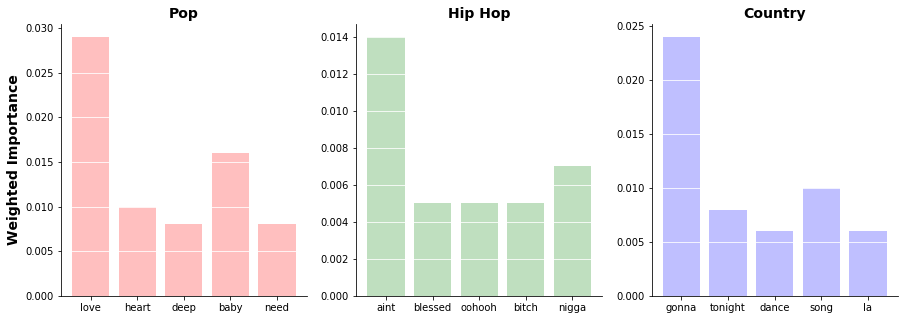

In [14]:
#using the output above (unforunately I could not figure out a way to make this more dynamic, so I just created the dataframe myself)
#I select these words based on the relative exclusivity I found using the dashboard above (i.e. check out how much of the red bar covers the blue bar for a word withina topic)
topic_1 = pd.DataFrame({'Word':['love','heart','deep','baby','need'],
'Frequency':[0.029,0.010,0.008,0.016,0.008]})
#potentially sensitive lingo in this bunch... just going to use what the data output was, but I am aware these are potentially offensive words
topic_2 = pd.DataFrame({'Word':['aint','blessed','oohooh','bitch','nigga'],
'Frequency':[0.014,0.005,0.005,0.005,0.007]})
topic_3 = pd.DataFrame({'Word':['gonna','tonight','dance','song','la'],
'Frequency':[0.024,0.008,0.006,0.010,0.006]})

#to plot
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax[0].bar(topic_1['Word'], topic_1['Frequency'], color='red', alpha=0.25)      
ax[0].grid(axis='y', color='white')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Pop',fontsize=14,fontweight='bold')
ax[0].set_ylabel('Weighted Importance',fontweight='bold',fontsize=14)

ax[1].bar(topic_2['Word'], topic_2['Frequency'], color='green', alpha=0.25)      
ax[1].grid(axis='y', color='white')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Hip Hop',fontsize=14,fontweight='bold')

ax[2].bar(topic_3['Word'], topic_3['Frequency'], color='blue', alpha=0.25)      
ax[2].grid(axis='y', color='white')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_title('Country',fontsize=14,fontweight='bold')
plt.savefig('Figure_3.png')
plt.show()

In [14]:
#usually takes about 15 seconds to run
#let's do this again, but getting rid of some of the "filler" words
#to clean up lyrics to prepare for topic modeling
stop = set(stopwords.words('english'))
add_stop = ["i'm", 'oh', 'get',"i'll",'one','go','you','got','yeah','say','see','like','la','two','on','up','let']
short_stop = stop.union(add_stop)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(lyric):
    stop_free = " ".join([i for i in lyric.lower().split() if i not in short_stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
lyrics_data_clean2 = [clean(lyric).split() for lyric in lyrics_data['Lyrics']]

In [15]:
#this is for my own sanity... I do the same thing as above but this time without words of 3 letters or less 
#I don't even put this output into the report
#setting up our dictionary
dictionary2 = corpora.Dictionary(lyrics_data_clean2)
#Converting each songs lyrics (corpus) into lyrics_term_matrix using dictionary prepared above.
lyrics_term_matrix2 = [dictionary2.doc2bow(lyric) for lyric in lyrics_data_clean2]

In [16]:
#to actually run the model (this cell takes awhile to run FYI -- usually about 2 minutes)
#try "setting the seed"
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(lyrics_term_matrix2, num_topics=3, id2word = dictionary2, passes=20,random_state=np.random.RandomState(20))
print(ldamodel2.print_topics(num_topics=3, num_words=5))

[(0, '0.031*"know" + 0.021*"want" + 0.018*"love" + 0.015*"take" + 0.015*"baby"'), (1, '0.012*"feel" + 0.011*"man" + 0.010*"way" + 0.010*"cause" + 0.010*"gonna"'), (2, '0.033*"love" + 0.017*"baby" + 0.012*"deep" + 0.012*"aint" + 0.011*"girl"')]


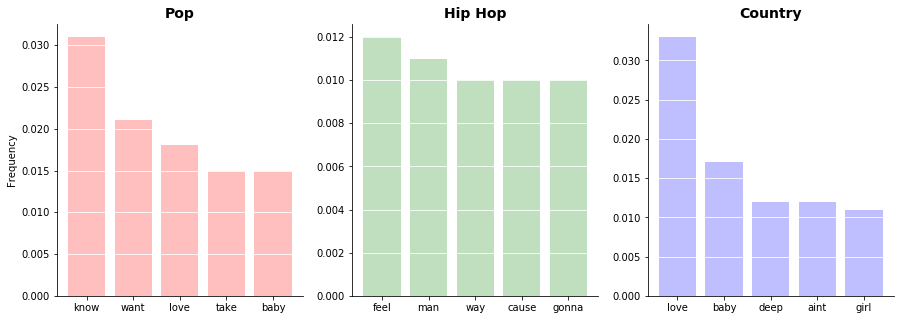

In [19]:
#using the output above (unforunately I could not figure out a way to make this more dynamic, so I just created the dataframe myself)
#this time I only use the top 5 most frequent words in each topic 
topic_1 = pd.DataFrame({'Word':['know','want','love','take','baby'],
'Frequency':[0.031,0.021,0.018,0.015,0.015]})
topic_2 = pd.DataFrame({'Word':['feel','man','way','cause','gonna'],
'Frequency':[0.012,0.011,0.010,0.010,0.010]})
topic_3 = pd.DataFrame({'Word':['love','baby','deep','aint','girl'],
'Frequency':[0.033,0.017,0.012,0.012,0.011]})

#to plot
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax[0].bar(topic_1['Word'], topic_1['Frequency'], color='red', alpha=0.25)      
ax[0].grid(axis='y', color='white')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Pop',fontsize=14,fontweight='bold')
ax[0].set_ylabel('Frequency')

ax[1].bar(topic_2['Word'], topic_2['Frequency'], color='green', alpha=0.25)      
ax[1].grid(axis='y', color='white')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Hip Hop',fontsize=14,fontweight='bold')

ax[2].bar(topic_3['Word'], topic_3['Frequency'], color='blue', alpha=0.25)      
ax[2].grid(axis='y', color='white')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_title('Country',fontsize=14,fontweight='bold')
plt.show()

### What Kind of Lyrics Should the Song Have?
I run some time-series regressions over data from our lyrics

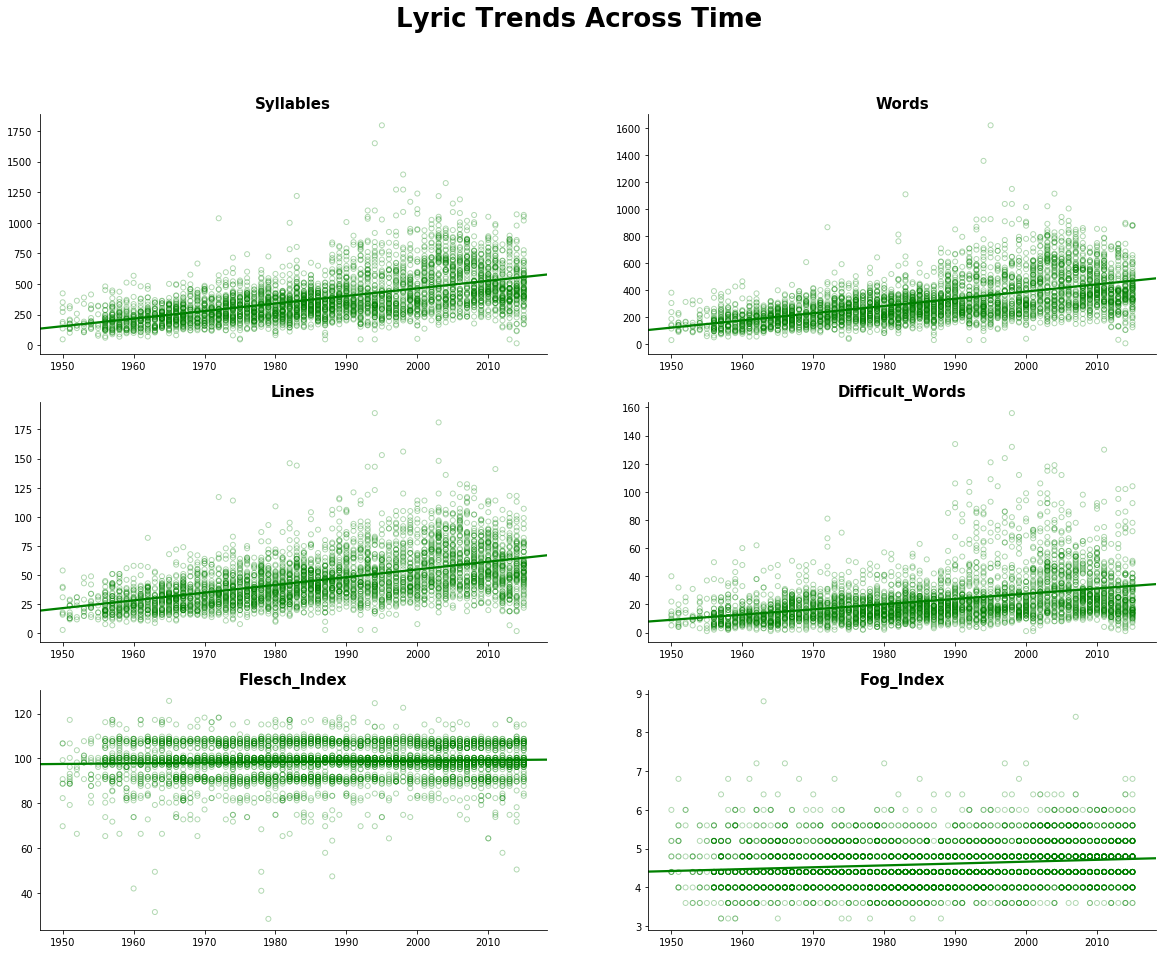

In [17]:
#usually takes about 15 seconds to run
#to visualize regressions and identify lyrical trends
#usually takes about 1 minute to run
cols_to_get = ['Words','Syllables','Difficult_Words','Lines','Fog_Index','Flesch_Index']
fig, ax = plt.subplots(3,2, figsize=(20,15))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.regplot(x='Year',y=var, data=lyrics_data,ci=0,color='green',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),0]).set_title(var, fontsize=15, fontweight="bold") 
        sns.despine() 
    else:
        sns.regplot(x='Year',y=var, data=lyrics_data,ci=0,color='green',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),1]).set_title(var, fontsize=15, fontweight="bold") 
        sns.despine() 
    counter = counter + 1
fig.suptitle("Lyric Trends Across Time", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_4.png')
plt.show()

In [21]:
#to find some averages at the beginning and end of the dataset
data_1950 = lyrics_data['Year'] == 1950
mean_1950 = lyrics_data.loc[data_1950, 'Words'].mean()
data_2015 = lyrics_data['Year'] == 2015
mean_2015 = lyrics_data.loc[data_2015, 'Words'].mean()
print('The average word count was', round(mean_1950,0), 'in 1950')
print('The average word count was', round(mean_2015,0), 'in 2015')

The average word count was 194.0 in 1950
The average word count was 412.0 in 2015


### What Kind of Musical Elements Should the Song Utilize?
I run some time-series regressions over data from our music

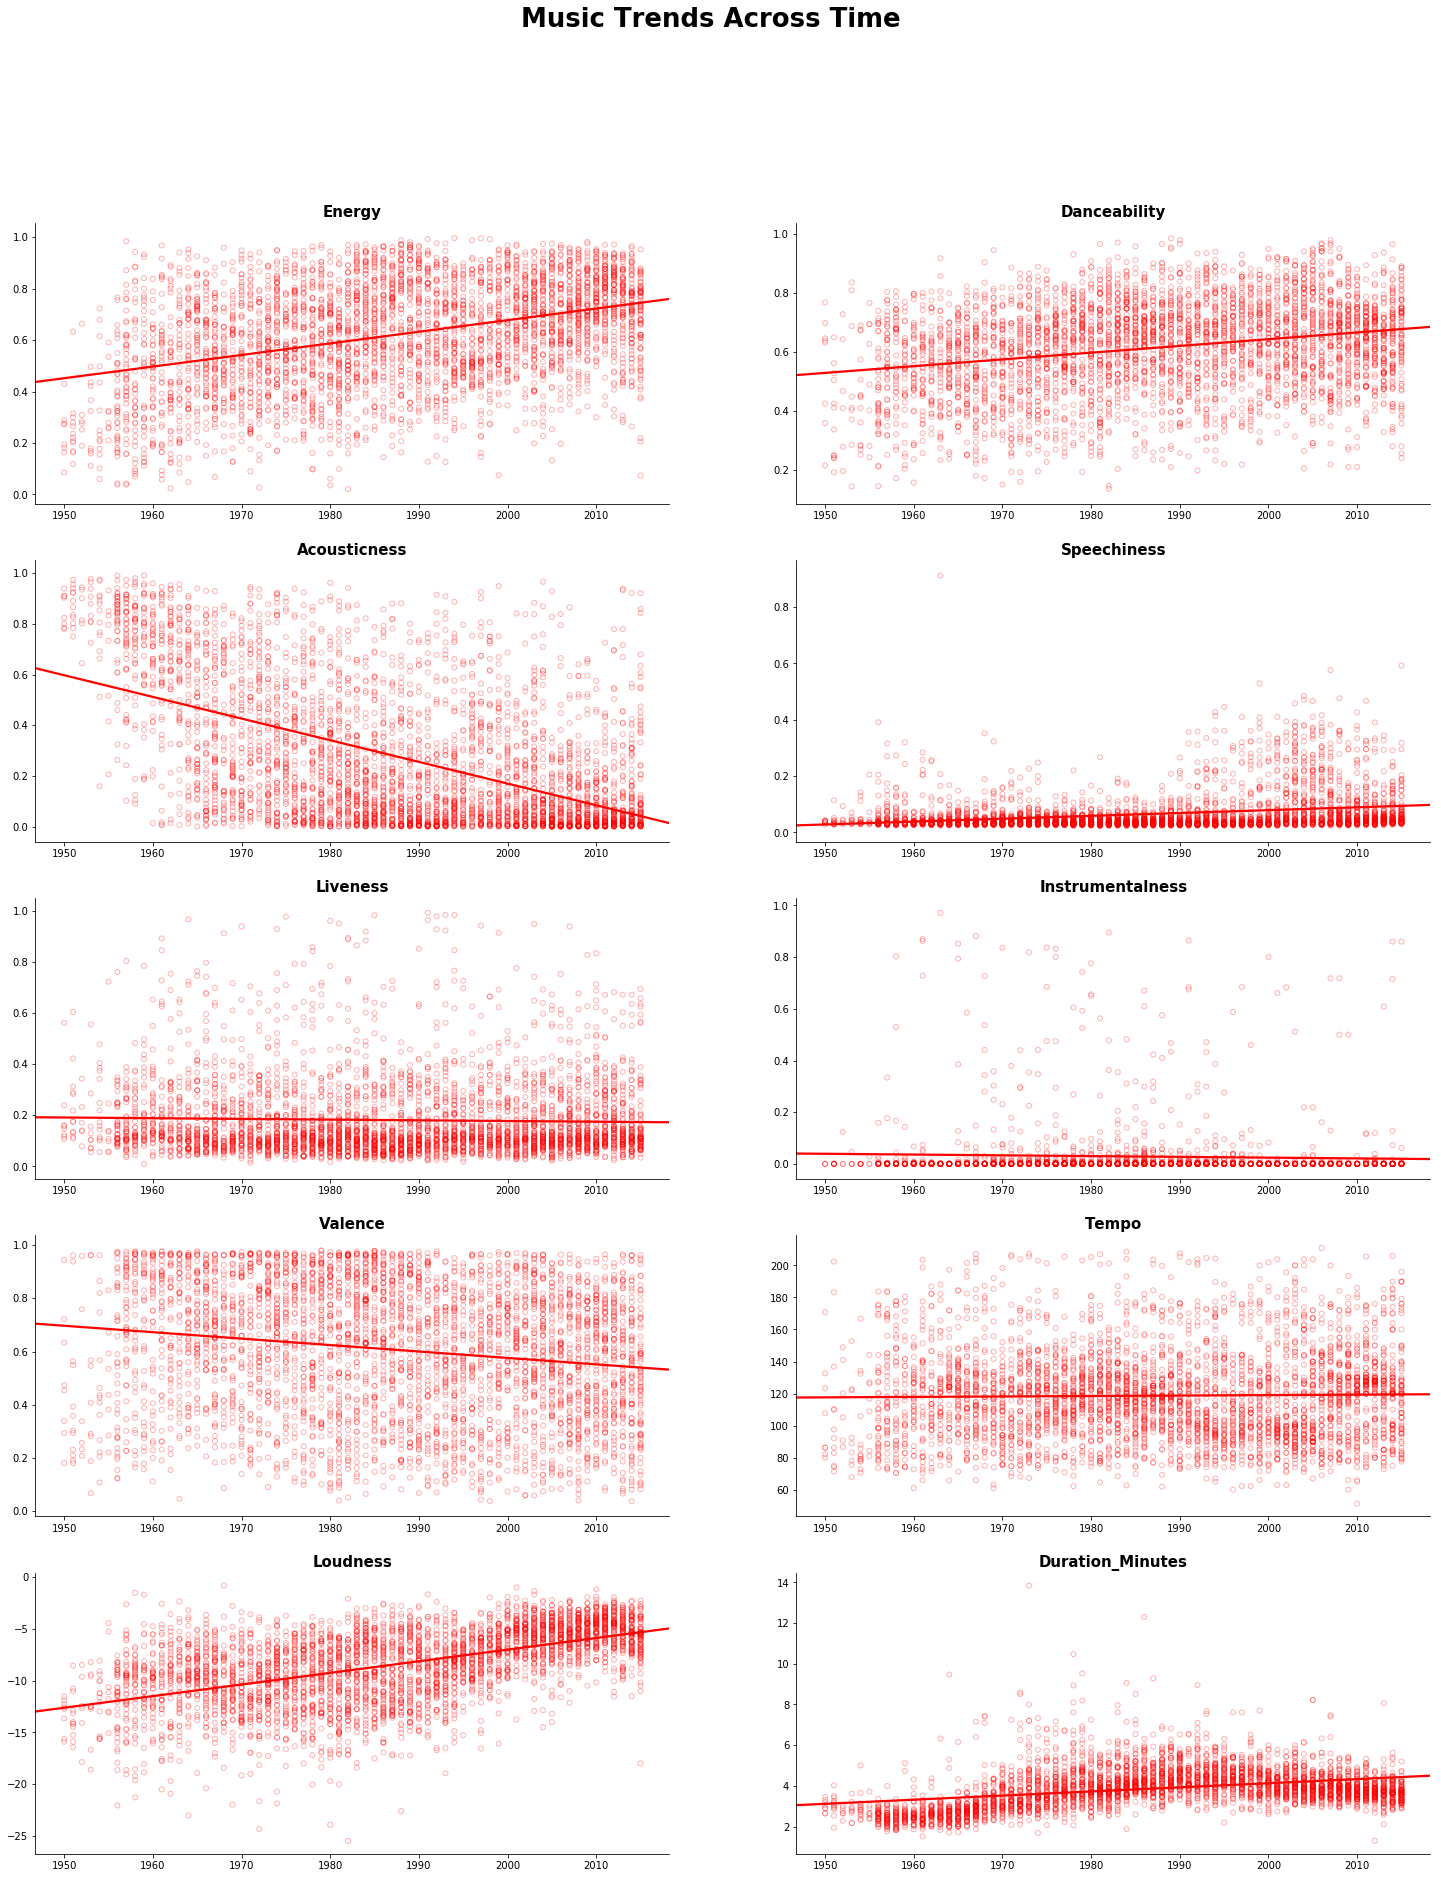

In [18]:
#usually takes about 15 seconds to run
#to see if there are significant differences accross time
#usually takes about 1 minute to run
cols_to_get = ['Danceability','Energy','Speechiness','Acousticness','Instrumentalness','Liveness','Tempo','Valence','Duration_Minutes','Loudness']
fig, ax = plt.subplots(5,2, figsize=(25,30))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.regplot(x='Year',y=var, data=lyrics_data,ci=0,color='red',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),0]).set_title(var, fontsize=15,fontweight="bold") 
        sns.despine()    
    else:
        sns.regplot(x='Year',y=var, data=lyrics_data,ci=0,color='red',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),1]).set_title(var, fontsize=15, fontweight="bold") 
        sns.despine() 
    counter = counter + 1
fig.suptitle("Music Trends Across Time", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_5.png')
plt.show()

### Who Should Perform the Song?
I look for trends accross the past 7 decades in terms to artist gender and group popularity in the Billboard Top 100

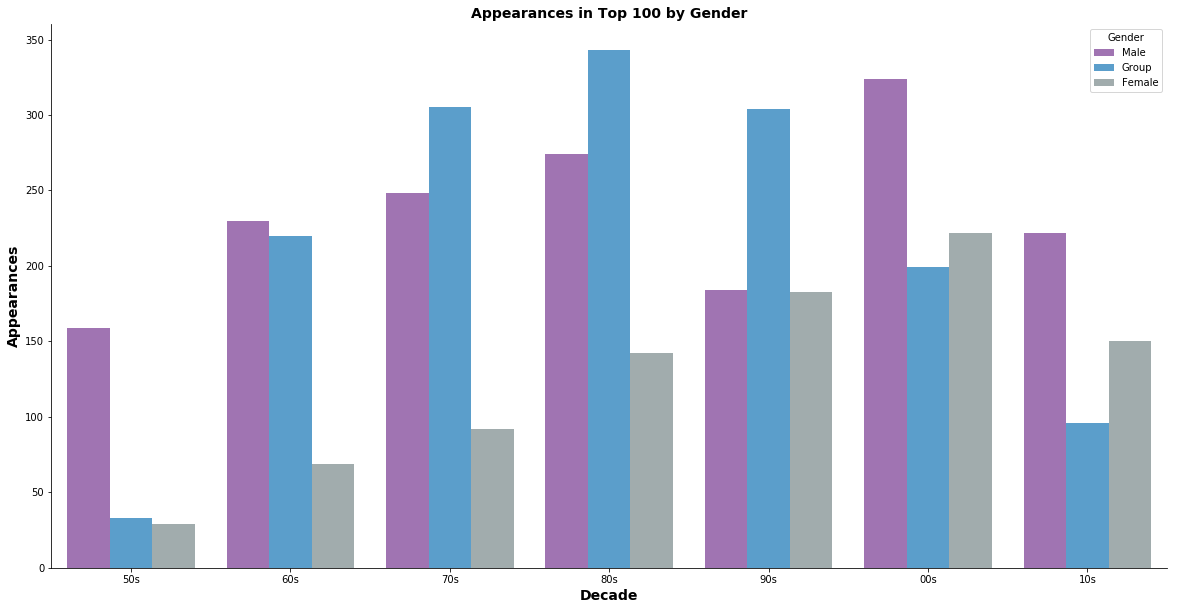

In [20]:
#to plot
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='Decade', hue='Gender',data=lyrics_data,palette=sns.color_palette(flatui), alpha=0.9, ax = ax)
sns.despine()
ax.set_title('Appearances in Top 100 by Gender',fontweight='bold',fontsize=14)
ax.set_ylabel('Appearances', fontweight='bold',fontsize=14)
ax.set_xlabel('Decade', fontweight='bold',fontsize=14)
plt.savefig('Figure_6.png')
plt.show()
#results indicate a rising amount of women in the top 100... that's in line with the domination of women in this year's grammy nominees

### Where Should the Song be Released?
I plot release locations on a world map, and each observation's size and color correspond to its popularity

In [24]:
#to create dataframe to use for mapping
song_data_location = song_data[['title','latitude', 'location', 'longitude','song.hotttnesss','year']]
song_data_location.rename(columns={'song.hotttnesss':'Popularity'}, inplace=True)
#ignore warning

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [25]:
#to create geopandas dataframe
song_data_location['coordinates'] = list(zip(song_data_location.longitude, song_data_location.latitude))
song_data_location['coordinates'] = song_data_location['coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(song_data_location, geometry='coordinates')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#ignore warning

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


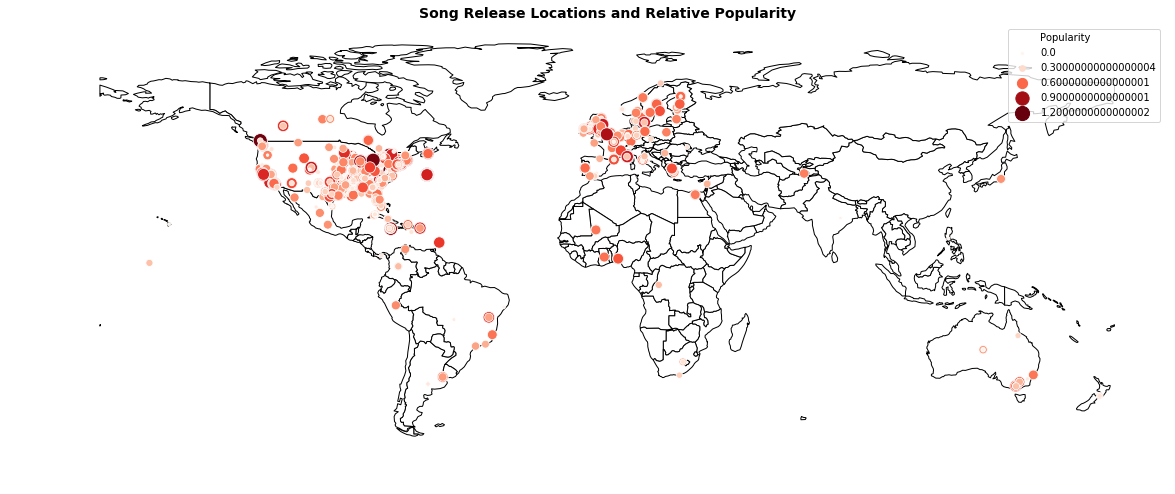

In [26]:
#to plot
fig, gax = plt.subplots(figsize=(20,25))
world[world['continent'] != 'Antarctica'].plot(ax = gax, edgecolor='black',color='white')
sns.scatterplot(x='longitude', y='latitude', data=gdf, size=gdf['Popularity'], sizes=(5,200), hue=gdf['Popularity'], palette='Reds', legend='brief')
gax.set_title('Song Release Locations and Relative Popularity', fontsize=14, fontweight='bold')
gax.set_axis_off()
plt.savefig('Figure_8.png')
plt.show()
#looks like chicago is the money area!
#I could not figure out how to fix the legend on this one! I KONW IT'S NOT GRAPHICALLY EXCELLENT but this was the best I could do!

### The rest of this workbook is data work that I did during my research, but decided not to include in my report (however, some of these images are in the appendices of the final report)

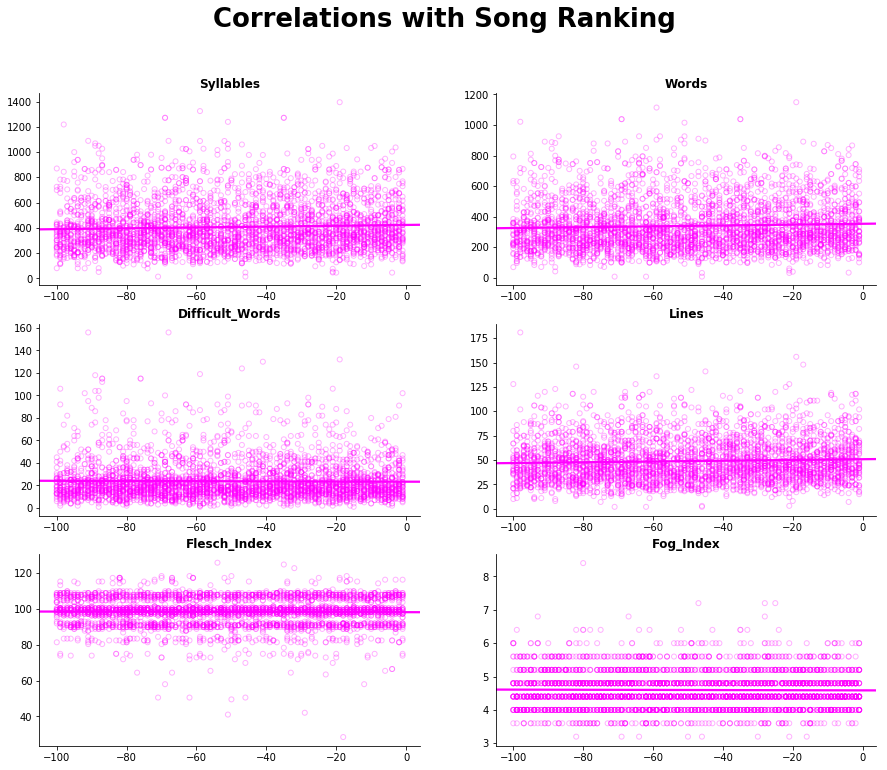

In [27]:
#usually takes about 15 seconds to run
#to see if there are significant differences between GOOD and GREAT songs
#I use "Inverse_Rank" to keep the best songs on the right side of the graph
#usually takes about 1 minutes to run
#to plot
cols_to_get = ['Words','Syllables','Lines','Difficult_Words','Fog_Index','Flesch_Index']
fig, ax = plt.subplots(3,2, figsize=(15,12))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.regplot(x='Inverse_Rank',y=var, data=music_data,ci=0,color='magenta',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),0]).set_title(var, fontweight="bold") 
        sns.despine()    
    else:
        sns.regplot(x='Inverse_Rank',y=var, data=music_data,ci=0,color='magenta',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),1]).set_title(var, fontweight="bold") 
        sns.despine() 
    counter = counter + 1
fig.suptitle("Correlations with Song Ranking", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_9.png')
plt.show()
#not very interesting results...

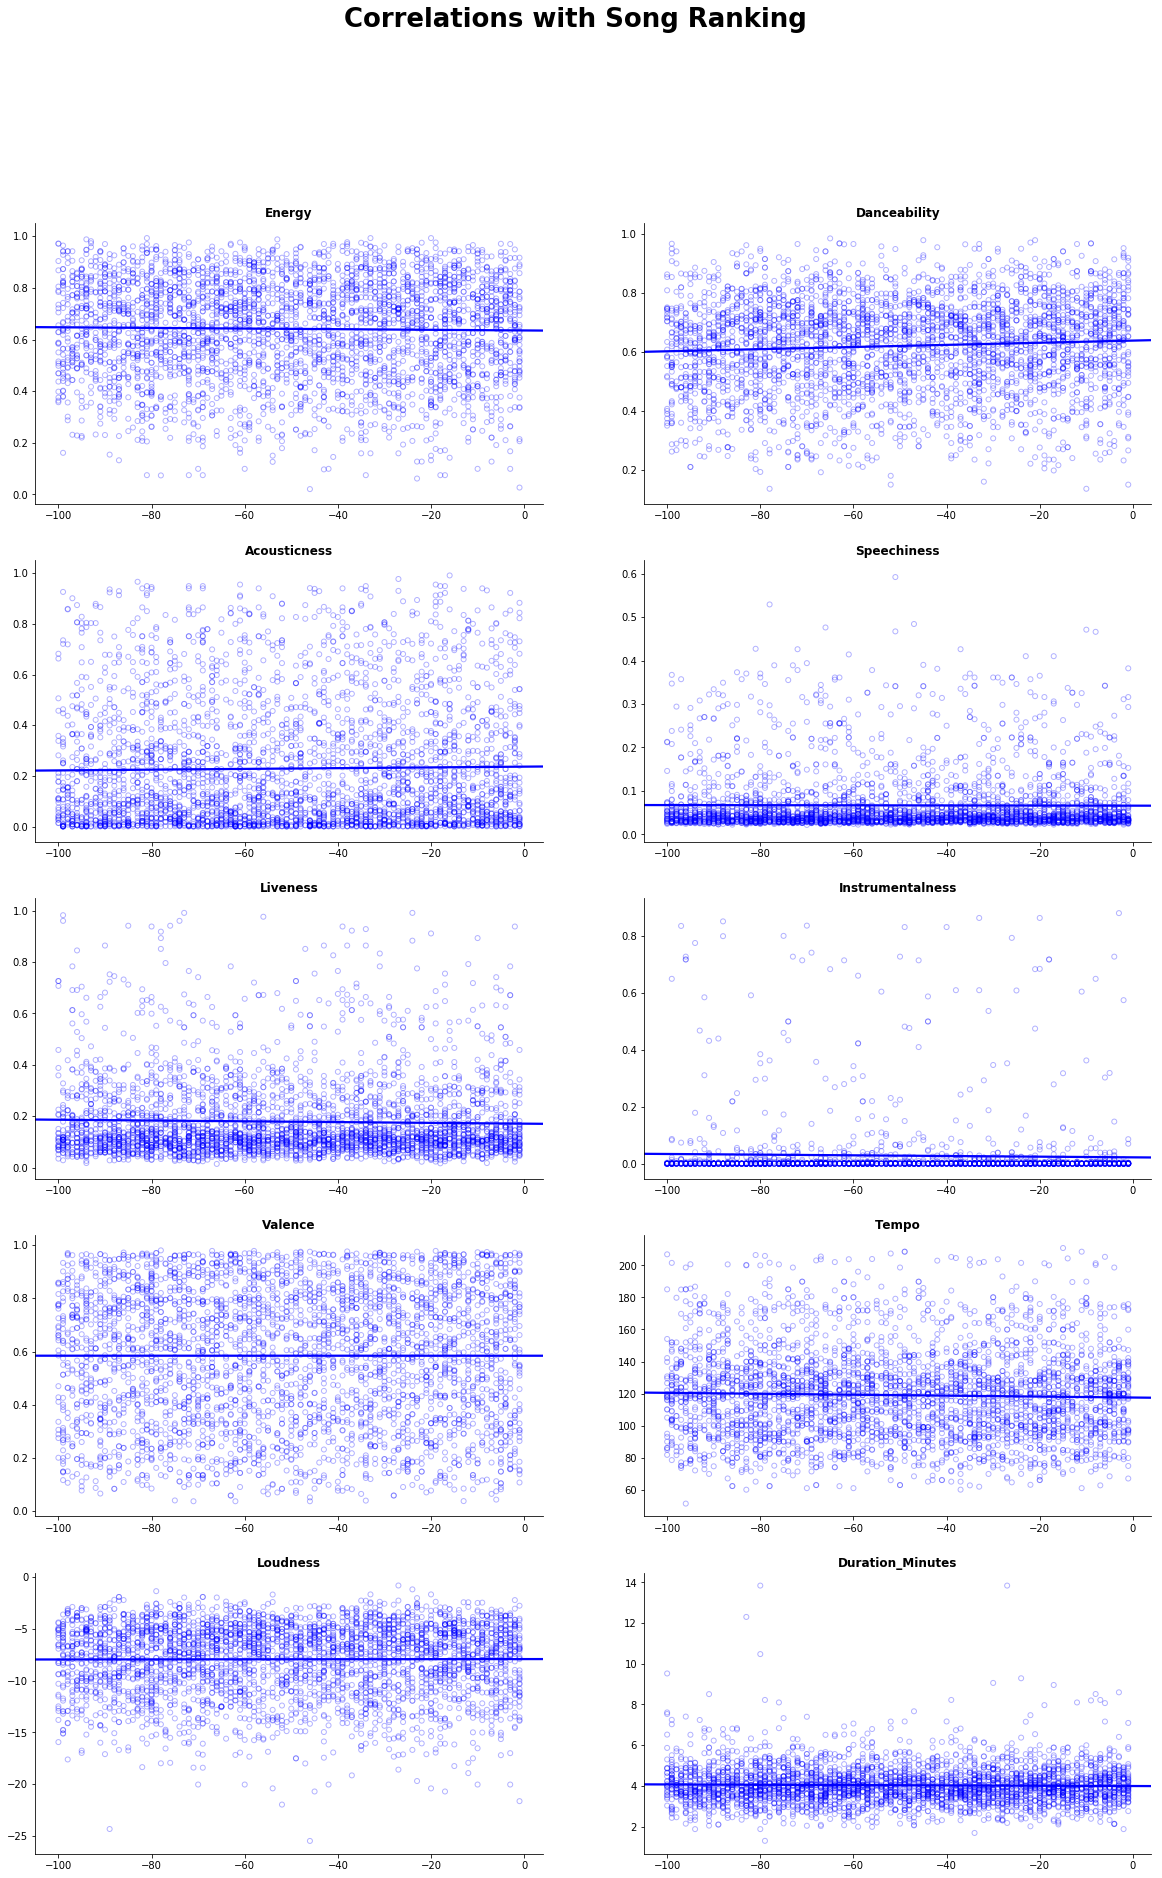

In [28]:
#usually takes about 15 seconds to run
#to see if there are significant differences between GOOD and GREAT songs
#I use "Inverse_Rank" to keep the best songs on the right side of the graph
#usually takes about 1 minutes to run
#to plot
cols_to_get = ['Danceability','Energy','Speechiness','Acousticness','Instrumentalness','Liveness','Tempo','Valence','Duration_Minutes','Loudness']
fig, ax = plt.subplots(5,2, figsize=(20,30))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.regplot(x='Inverse_Rank',y=var, data=music_data,ci=0,color='blue',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),0]).set_title(var, fontweight="bold") 
        sns.despine()    
    else:
        sns.regplot(x='Inverse_Rank',y=var, data=music_data,ci=0,color='blue',scatter_kws={'s':25, 'facecolor':'none','alpha':0.3},ax = ax[math.floor(counter/2),1]).set_title(var, fontweight="bold") 
        sns.despine() 
    counter = counter + 1
fig.suptitle("Correlations with Song Ranking", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_10.png')
plt.show()
#not very interesting results...

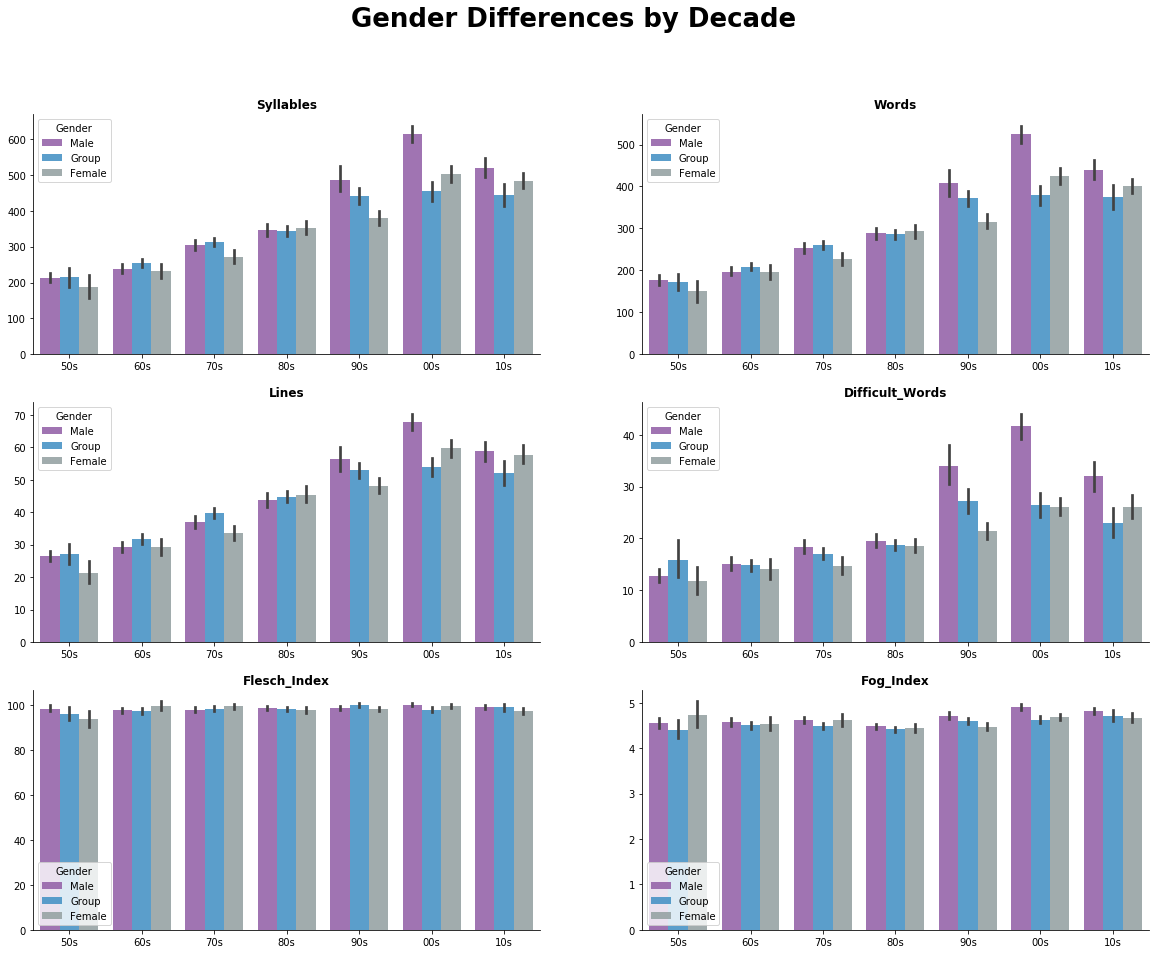

In [29]:
#usually takes about 15 seconds to run
#I wanted to explore how different genders are expected to perform differently, at least as indicated by commercial success
#to plot
cols_to_get = ['Words','Syllables','Difficult_Words','Lines','Fog_Index','Flesch_Index']
fig, ax = plt.subplots(3,2, figsize=(20,15))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.barplot(x='Decade',y=var, hue='Gender',data=lyrics_data,palette=sns.color_palette(flatui), alpha=0.9,ax = ax[math.floor(counter/2),0]).set_title(var, fontweight="bold") 
        sns.despine()    
    else:
        sns.barplot(x='Decade',y=var, hue='Gender',data=lyrics_data,palette=sns.color_palette(flatui), alpha=0.9,ax = ax[math.floor(counter/2),1]).set_title(var, fontweight="bold") 
        sns.despine()
    counter = counter + 1
fig.suptitle("Gender Differences by Decade", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_11.png')
plt.show()
#some of these results are fascinating!
#not happy i couldn't remove the legends for all but one of the axes....

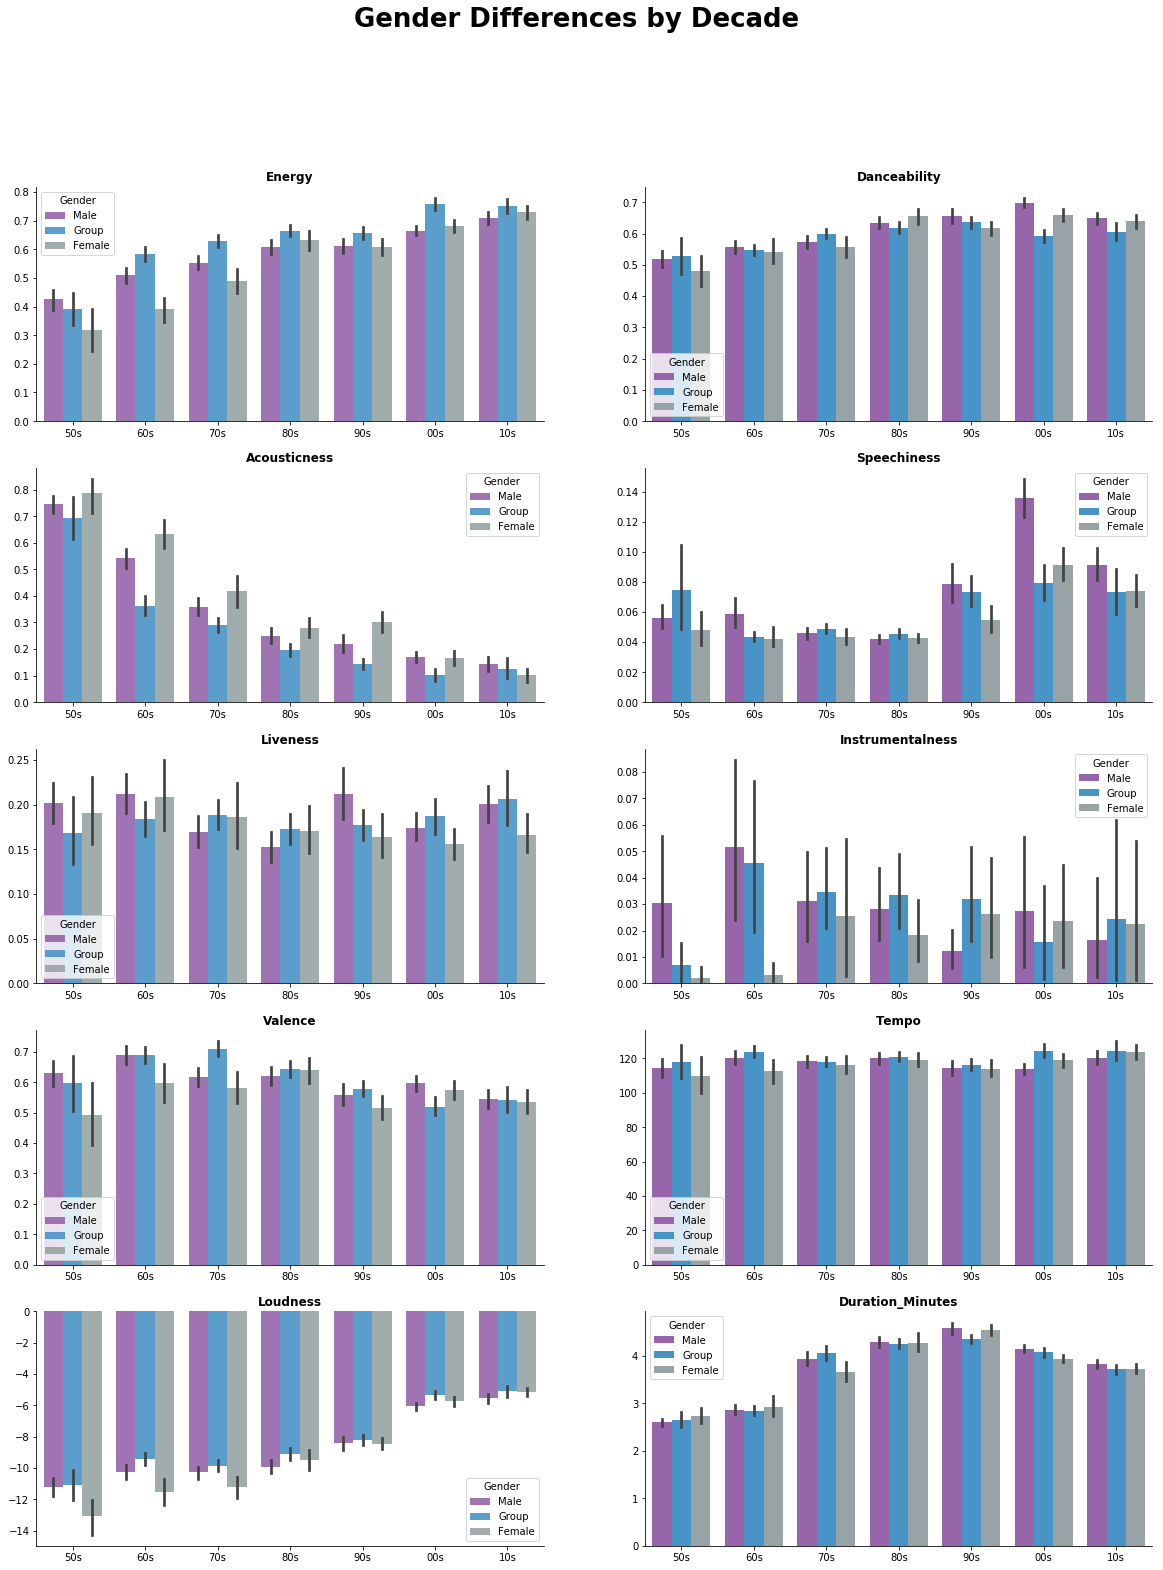

In [30]:
#usually takes about 15 seconds to run
#more gender stuff... 
#to plot
cols_to_get = ['Danceability','Energy','Speechiness','Acousticness','Instrumentalness','Liveness','Tempo','Valence','Duration_Minutes','Loudness']
fig, ax = plt.subplots(5,2, figsize=(20,25))
counter = 0
for var in cols_to_get:
    if counter%2 == 1:
        sns.barplot(x='Decade',y=var, hue='Gender',data=lyrics_data,palette=sns.color_palette(flatui), alpha=0.9, ax = ax[math.floor(counter/2),0]).set_title(var, fontweight="bold") 
        sns.despine()    
    else:
        sns.barplot(x='Decade',y=var, hue='Gender',data=lyrics_data,palette=sns.color_palette(flatui), ax = ax[math.floor(counter/2),1]).set_title(var, fontweight="bold") 
        sns.despine()
    counter = counter + 1
fig.suptitle("Gender Differences by Decade", fontsize = 26, fontweight = "bold")
for ax in ax.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('Figure_12.png')
plt.show()
#fascinating!

In [31]:
#to see if location has changed over time
#after exploring the data, I found these two bins to show a meaningful shift
gdf_50s_80s = gdf[(gdf['year']>=1950) & (gdf['year']<1990)]
gdf_90s_10s = gdf[gdf['year']>=1990]

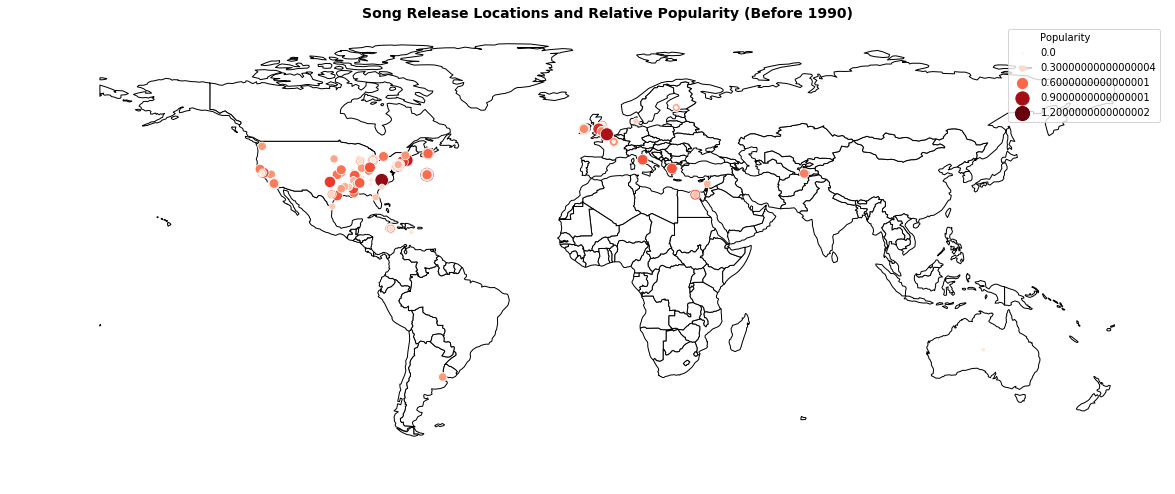

In [32]:
#to plot
fig, gax = plt.subplots(figsize=(20,25))
world[world['continent'] != 'Antarctica'].plot(ax = gax, edgecolor='black',color='white')
sns.scatterplot(x='longitude', y='latitude', data=gdf_50s_80s, size=gdf['Popularity'], sizes=(5,200), hue=gdf['Popularity'], palette='Reds')
gax.set_title('Song Release Locations and Relative Popularity (Before 1990)', fontweight='bold', fontsize=14)
gax.set_axis_off()
plt.show()

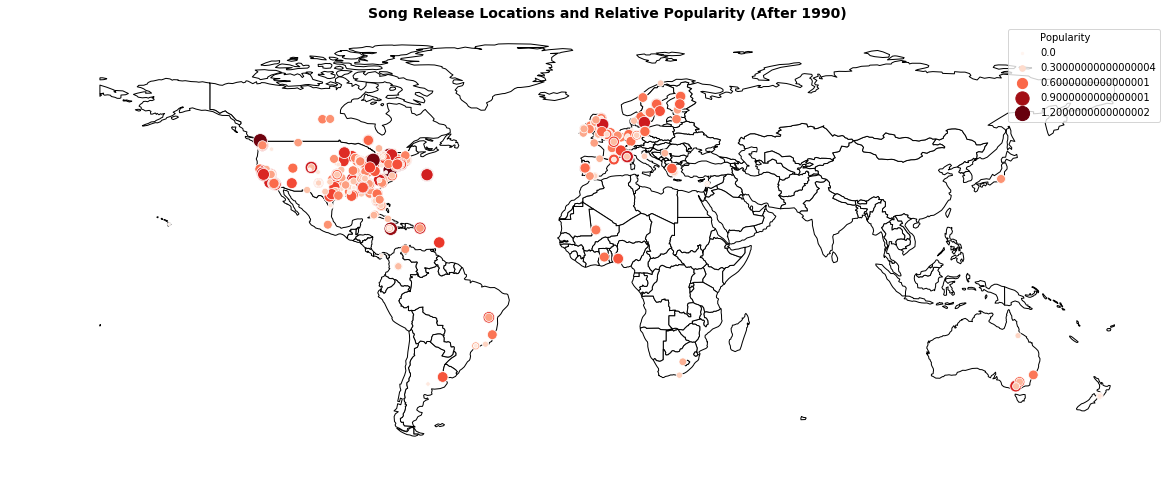

In [33]:
#we can see that hits are being written away from east united states and away from western europe -- there seems to be divergence from the atlantic
#to plot
fig, gax = plt.subplots(figsize=(20,25))
world[world['continent'] != 'Antarctica'].plot(ax = gax, edgecolor='black',color='white')
sns.scatterplot(x='longitude', y='latitude', data=gdf_90s_10s, size=gdf['Popularity'], sizes=(5,200), hue=gdf['Popularity'], palette='Reds')
gax.set_title('Song Release Locations and Relative Popularity (After 1990)', fontweight='bold', fontsize=14)
gax.set_axis_off()
plt.show()